<a href="https://colab.research.google.com/github/jan-kreischer/UZH_Network-Science_Final-Project/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project on Epidemics on Networks

## 1. Setup
### 1.1 Dependencies
Installing all dependencies needed to run the simulations

In [ ]:
! pip install EoN
! pip install PySPG
! pip install powerlaw
! pip install tenacity

     |████████████████████████████████| 113 kB 5.2 MB/s 
  Created wheel for EoN: filename=EoN-1.1-py3-none-any.whl size=120819 sha256=1803c500befc62649fd325e666218c35d7ccfa3719533f5a51ff1215ba66385c
  Stored in directory: /root/.cache/pip/wheels/0b/c0/a4/d6001fd809cb84c027ada5c2ab3b6d1cb2e97fec3f9978eae7
Successfully built EoN
     |████████████████████████████████| 76 kB 2.6 MB/s 


### 1.2 Imports

In [ ]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import networkx as nx
import math as m

from tabulate import tabulate

from tenacity import retry

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import torch
from collections import defaultdict
import random

import random as rnd
from random import shuffle

import powerlaw
import EoN

### 1.3 Constants

In [ ]:
n_switzerland = 8.6 * (10**6)
n_canton_zurich = 1.5* (10**6)
n_zurich_city = 400000
n_uzh = 26000
n_ifi = 3000
n_ns_class = 150

DEFAULT_INFECTION_RATE = 0.25
DEFAULT_RECOVERY_RATE = 1
DEFAULT_INITIAL_SIZE = 1

N_ITERATIONS = 10

TMIN = 60 # Minimum Report Time
DEFAULT_TMIN = TMIN

TMAX = 60 # Maximum Report Time
DEFAULT_TMAX = TMAX

S_COLOR = "blue"
S_LINESTYLE = "dotted"
S_LABEL = "Susceptible"

I_COLOR = "crimson"
I_LINESTYLE = "dashed"
I_LABEL = "Infected"

R_COLOR = "lime"
R_LINESTYLE = 'solid'
R_LABEL = 'Recovered'

### 1.4 Environment
We check if the environment we are using is properly setup, such that we are using GPU for training our models.  
Furthermore the data stored in google drive is made accessible.

In [ ]:
# Check Memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Enable access to files stored in Google Drive
from google.colab import drive
# Leave this like it is
mountpoint = '/content/drive/' 
drive.mount(mountpoint)

Mounted at /content/drive/


In [ ]:
# Adapt this path to the folder where your data is stored in google drive
data_path = 'My Drive/UZH_Network-Science/Projects/Final-Project/data' 
complete_path = os.path.join(mountpoint, data_path)
# Cd into the directory with the git repo
% cd $complete_path

/content/drive/My Drive/UZH_Network-Science/Projects/Final-Project/data


### 1.5 Functions
#### 1.5.1 Self Defined Functions

In [ ]:
def average(lst):
    return sum(lst)/len(lst)

In [ ]:
def load_graph(graph_name):
  graph = nx.read_gml(graph_name)
  return graph


#### 1.5.2 EoN Library Functions
*EoN.Gillespie_SIR(**G**, **tau**, **gamma**, **initial_infecteds**=None, **initial_recovereds**=None, **rho**=None, **tmin**=0, **tmax**=inf, **recovery_weight**=None, **transmission_weight**=None, **return_full_data**=False, **sim_kwargs**=None)*
- **G** ... [networkx Graph] representing the underlying network
- **tau** ... [positive float] transmission rate per edge
- **gamma** ... [number] recovery rate per node
- **initial_infecteds** ... node or iterable of nodes if a single node, then this node is initially infected if an iterable, then whole set is initially infected if None, then choose randomly based on rho. If rho is also None, a random single node is chosen. If both initial_infecteds and rho are assigned, then there is an error.
- **initial_recovereds** ... iterable of nodes (default None)
this whole collection is made recovered. Currently there is no test for consistency with initial_infecteds. Understood that everyone who isn’t infected or recovered initially is initially susceptible.
- **rho** ... number initial fraction infected. number is int(round(G.order()*rho))
- **tmin** ... number (default 0) starting time
- **tmax** ... number (default Infinity) stop time
- **recovery_weight** ... string (default None) the string used to define the node attribute for the weight. Assumes that the recovery rate is gamma*G.nodes[u][recovery_weight]. If None, then just uses gamma without scaling.
- **transmission_weight** ... string (default None)
the string used to define the edge attribute for the weight. Assumes that the transmission rate from u to v is tau*G.adj[u][v][transmission_weight] If None, then just uses tau without scaling.
- **return_full_data** ... boolean (default False)
Tells whether a Simulation_Investigation object should be returned.
- **sim_kwargs** ... keyword arguments Any keyword arguments to be sent to the Simulation_Investigation object Only relevant if return_full_data=True

## 2. Graphs
### 2.1 Graph Metrics

In [ ]:
def plot_degree_distribution(graph, graph_name, i, xscale='linear', yscale='linear', n_bins=20, density=True, ):
    plt.subplot(1, 3, i)
    graph_degrees = graph.degree()
    graph_degrees = [graph_degrees[i] for i in graph.nodes()]
    #fig, ax = plt.subplots()
    title = "{}\nDegree Distribution ".format(graph_name)

    if xscale == 'log':
        title+="Log"
        bins = np.logspace(np.log10(min(graph_degrees)),np.log10(max(graph_degrees)), n_bins)
        plt.hist(graph_degrees, bins=bins, density = density, alpha=0.5)
        plt.xlabel('log k')
    else:
        title+="Lin"
        bins = np.linspace(0, max(graph_degrees), n_bins)
        plt.hist(graph_degrees, bins = bins, density = density, alpha=0.5)
        plt.xlabel('k')
        
    if yscale == 'log':
        plt.ylabel("log P(k)")
        title+="-Log Scale"
    else:
        plt.ylabel("P(k)")
        title+="-Lin Scale"
    
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.title(title)
  

In [ ]:
def plot_degree_distributions(graph, graph_name, n_bins=20, density=True):
  fig, axis = plt.subplots(1,3,figsize=(15,4))
  plot_degree_distribution(graph, graph_name, 1, xscale='linear', yscale='linear', n_bins=n_bins, density=density)
  plot_degree_distribution(graph, graph_name, 2, xscale='log', yscale='linear', n_bins=n_bins, density=density)
  plot_degree_distribution(graph, graph_name, 3, xscale='log', yscale='log', n_bins=n_bins, density=density)
  plt.show()

In [ ]:
#Compute average degree <k> of the graph
def get_average_degree(graph):
    graph_degrees = graph.degree()
    graph_degrees = [graph_degrees[i] for i in graph.nodes()]
    n_edges = sum(graph_degrees)
    n_nodes = len(graph.nodes())
    average_degree = n_edges / n_nodes
    return average_degree

In [ ]:
def quantify_graph(graph):
  number_of_nodes = graph.number_of_nodes()
  number_of_edges = graph.number_of_edges()
  avg_degree = get_average_degree(graph)
  average_clustering_coefficient = nx.average_clustering(graph)
  degree_assortativity_coefficient = nx.degree_assortativity_coefficient(graph, weight = None)
  is_weighted = nx.is_weighted(graph)
  is_directed = nx.is_directed(graph)
  is_connected = nx.is_connected(graph)
  
  density = nx.density(graph)
  if is_connected:
    diameter = nx.diameter(graph)

  graph_degrees = graph.degree()
  degrees = [graph_degrees[i] for i in graph.nodes()]
  
  print("Number of Nodes: {}".format(number_of_nodes))
  print("Number of Edges: {}".format(number_of_edges))

  print("Is directed: {}".format(is_directed))
  print("Is weighted: {}".format(is_weighted))
  print("Is connected: {}".format(is_connected))

  print("Density: {}%".format(round(density*100, 4)))
  if is_connected:
    print("Diameter: {}".format(diameter))

  print("Min Node Degree: {}".format(min(degrees)))
  print("Max Node Degree: {}".format(max(degrees)))
  print("Average Node Degree: <k> ≈ {}".format(round(avg_degree, 2)))
  print("Average Clustering Coefficient: {}".format(round(average_clustering_coefficient, 4)))
  print("Degree Assortativity Coefficient: {}".format(round(degree_assortativity_coefficient, 4)))
  deg = np.asarray([d for d in dict(graph.degree()).values()])
  
  results = powerlaw.Fit(deg, discrete=True, verbose=False) #
  gamma = results.power_law.alpha # Although the powerlaw package calls the exponent alpha we called it gamma in our formula
  print("Fitted power law-exponent: Ɣ ≈ {}".format(round(gamma, 2)))
  sigma = results.power_law.sigma
  print('Standard error of fit: σ ≈ {}'.format(round(sigma, 4)))
    
  #Plot the degree distribution (histogram & log-log scale) 
  average_degree = get_average_degree(graph)
  #plot_distributions(degrees, average_degree)

### 2.2 Synthetic Graphs
#### 2.2.1 Barabási-Albert graph
*barabasi_albert_graph(n, m, seed=None)*.  
n ... [int] ... Number of nodes.  
m ... [int] ... Number of edges to attach from a new node to existing nodes.  

In [ ]:
ba_n_1000_k_10 = nx.barabasi_albert_graph(1000, 5)
quantify_graph(ba_n_1000_k_10)

Number of Nodes: 1000
Number of Edges: 2991
Is directed: False
Is weighted: False
Is connected: True
Density: 0.005987987987987988
Diameter: 6
Min Node Degree: 3
Max Node Degree: 86
Average Node Degree: <k> ≈ 5.98
Average Clustering Coefficient: 0.0389
Degree Assortativity Coefficient: -0.0967
Fitted power law-exponent: Ɣ ≈ 2.68
Standard error of fit: σ ≈ 0.0686


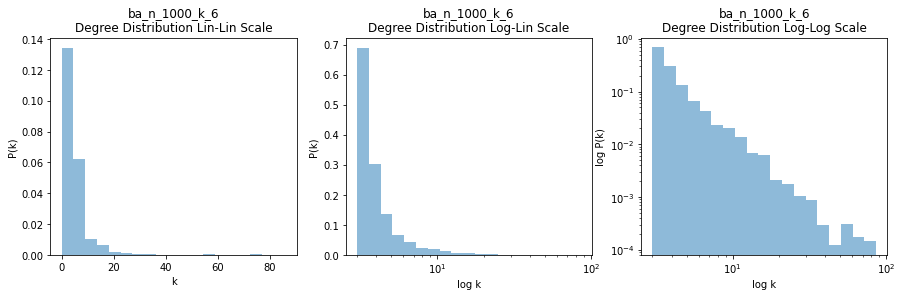

In [ ]:
plot_degree_distributions(ba_n_1000_k_10, "ba_n_1000_k_10", n_bins=20, density=True)

#### 2.2.2 Erdős-Rényi graph
*erdos_renyi_graph(n, p, seed=None, directed=False)*.  
The  model chooses each of the possible edges with probability p.  
n ... Number of nodes. 
p ... Probability of edge creation. 

In [ ]:
def erdos_renyi_graph(n, k):
  p = k/n
  return nx.erdos_renyi_graph(n, p, directed=False)

In [ ]:
er_n_1000_k_10 = erdos_renyi_graph_with_average_degree(1000, 6)
quantify_graph(er_n_1000_k_10)

Number of Nodes: 1000
Number of Edges: 2976
Is directed: False
Is weighted: False
Is connected: False
Density: 0.005957957957957958
Min Node Degree: 0
Max Node Degree: 16
Average Node Degree: <k> ≈ 5.95
Average Clustering Coefficient: 0.0075
Degree Assortativity Coefficient: -0.0283
Fitted power law-exponent: Ɣ ≈ 9.05
Standard error of fit: σ ≈ 0.8534


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/numpy/core/function_base.py:144: RuntimeWarning: invalid value encountered in multiply
  y *= step
/usr/local/lib/python3.7/dist-packages/numpy/core/function_base.py:154: RuntimeWarning: invalid value encountered in add
  y += start


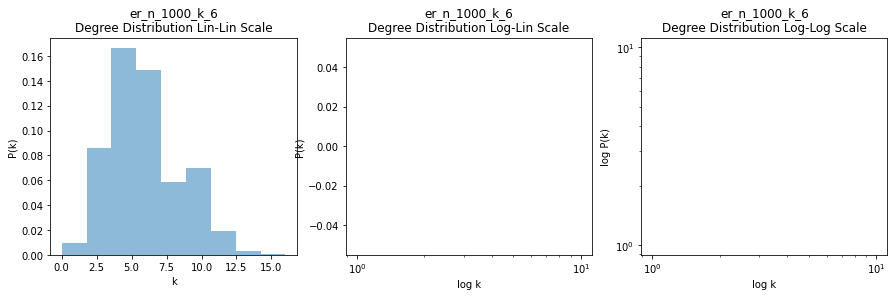

In [ ]:
plot_degree_distributions(er_n_1000_k_10, "er_n_1000_k_10", n_bins=10, density=True)

#### 2.2.3 Watts Strogatz graph
*watts_strogatz_graph(n, k, p, seed=None)*.  
n ... [int] ... The number of nodes.  
k ... [int] ... Each node is connected to k nearest neighbors in ring topology.  
p ... [float] ... The probability of rewiring each edge.  
seed ..[int] ...optional Seed for random number generator (default=None)  


In [ ]:
ws_n_1000_k_10 = nx.watts_strogatz_graph(n=1000, k=10, p=0.5)
quantify_graph(ws_n_1000_k_10)

Number of Nodes: 1000
Number of Edges: 3000
Is directed: False
Is weighted: False
Is connected: True
Density: 0.006006006006006006
Diameter: 7
Min Node Degree: 3
Max Node Degree: 12
Average Node Degree: <k> ≈ 6.0
Average Clustering Coefficient: 0.0876
Degree Assortativity Coefficient: -0.0508
Fitted power law-exponent: Ɣ ≈ 8.94
Standard error of fit: σ ≈ 0.63


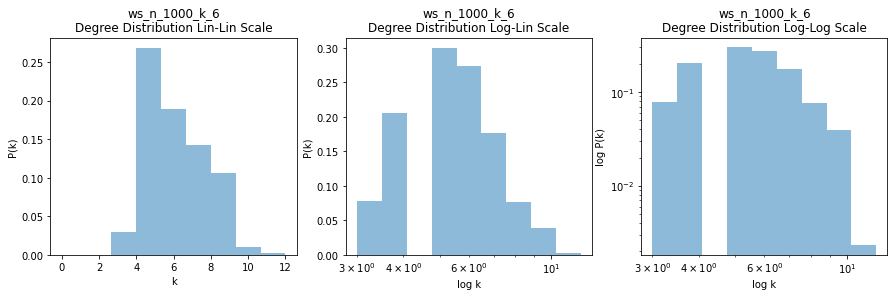

In [ ]:
plot_degree_distributions(ws_n_1000_k_10, "ws_n_1000_k_10", n_bins=10, density=True)

### 2.3 Real World Graphs
#### 2.3.1 Facebook Graph

In [ ]:
facebook_friendship_graph = load_graph("graph_facebook.gml")

In [ ]:
quantify_graph(facebook_friendship_graph)

Number of Nodes: 4039
Number of Edges: 88234
Is directed: False
Is weighted: False
Is connected: True
Density: 1.082%
Diameter: 8
Min Node Degree: 1
Max Node Degree: 1045
Average Node Degree: <k> ≈ 43.69
Average Clustering Coefficient: 0.6055
Degree Assortativity Coefficient: 0.0636
Fitted power law-exponent: Ɣ ≈ 2.51
Standard error of fit: σ ≈ 0.0427


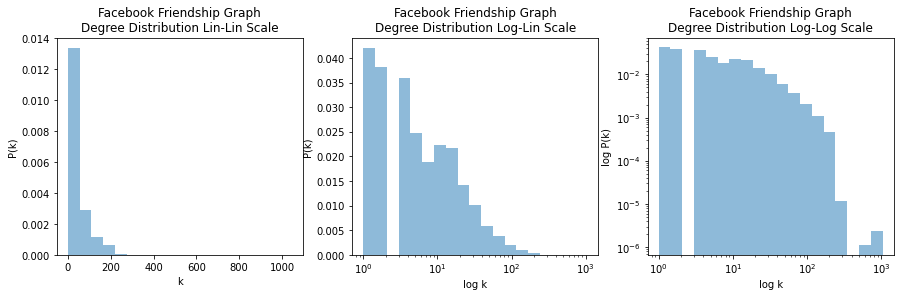

In [ ]:
plot_degree_distributions(facebook_friendship_graph, "Facebook Friendship Graph", n_bins=20, density=True)

#### 2.3.2 Escorts Graph

In [ ]:
sex_escort_graph = load_graph("graph_escort.gml")

In [ ]:
quantify_graph(sex_escort_graph)

Number of Nodes: 16730
Number of Edges: 39044
Is directed: False
Is weighted: False
Is connected: False
Density: 0.0279%
Min Node Degree: 1
Max Node Degree: 305
Average Node Degree: <k> ≈ 4.67
Average Clustering Coefficient: 0.0
Degree Assortativity Coefficient: -0.1097
Fitted power law-exponent: Ɣ ≈ 2.87
Standard error of fit: σ ≈ 0.0758


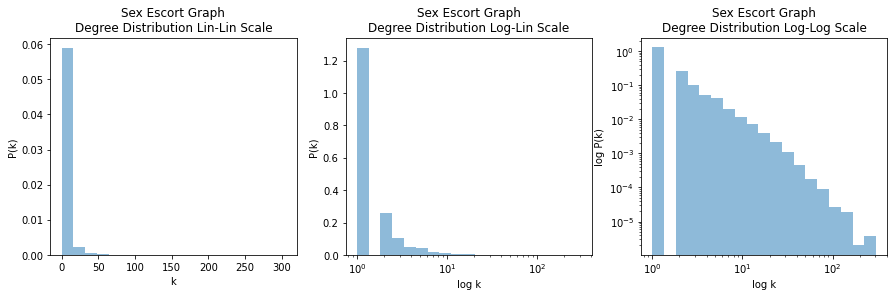

In [ ]:
plot_degree_distributions(sex_escort_graph, "Sex Escort Graph", n_bins=20, density=True)

#### 2.3.3 Contact Tracing Graph

In [ ]:
def read_haslemere_graph():
  # First we read the CSV: Contact tracing data over 3 days
  tracing_df = pd.read_csv("https://raw.githubusercontent.com/skissler/haslemere/master/Kissler_DataS1.csv")
  tracing_df.info()
  tracing_graph = nx.Graph()
  # Then we add for every contact <= 5m an edge with the attribute distance that shows the exact distance
  for index, row in tracing_df.iterrows():
      if row[3] <= 5 and not tracing_graph.has_edge(row[1], row[2]):
        tracing_graph.add_edge(int(row[1]), int(row[2]), distance=row[3], timestep=row[0])
  return tracing_graph
contact_tracing_graph = read_haslemere_graph()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102830 entries, 0 to 102829
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   1       102830 non-null  int64
 1   1.1     102830 non-null  int64
 2   390     102830 non-null  int64
 3   17      102830 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [ ]:
quantify_graph(contact_tracing_graph)

Number of Nodes: 418
Number of Edges: 1350
Is directed: False
Is weighted: False
Is connected: False
Density: 1.549%
Min Node Degree: 1
Max Node Degree: 37
Average Node Degree: <k> ≈ 6.46
Average Clustering Coefficient: 0.2032
Degree Assortativity Coefficient: 0.061
Fitted power law-exponent: Ɣ ≈ 3.0
Standard error of fit: σ ≈ 0.1566


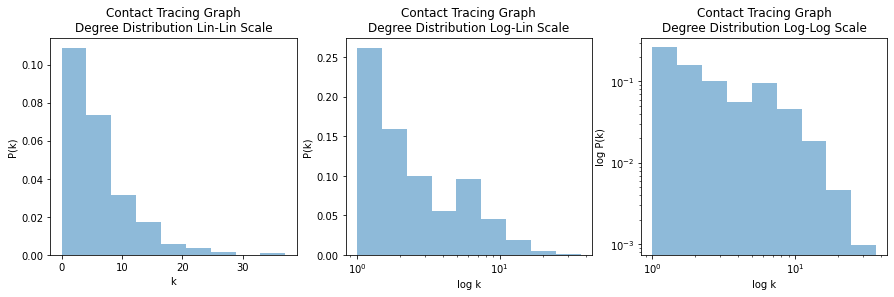

In [ ]:
plot_degree_distributions(contact_tracing_graph, "Contact Tracing Graph", n_bins=10, density=True)

## 3. Experiments

### 3.1 Experiment 1

In [ ]:
def gillespie_wellmixed(N, recovery_rate, infection_rates, initial_infection_rate, r):
    # creating 20 values between 0 and 0.3
    betas = infection_rates
    
    avg_fraction_per_beta = []
    
    for beta in betas:
        R_per_run = []  

        for i in range (0,r):
            S_Init = np.zeros(int(N-N*initial_infection_rate),dtype=int)
            I_Init = np.ones(int(N*initial_infection_rate),dtype=int)
            populationvector = np.append(S_Init,I_Init)
            np.random.shuffle(populationvector)
            time = 0

            while np.sum( populationvector == 1 ) > 0:
                # calculating aggregated infection and recovery rates
                infection_rate = ((np.sum( populationvector == 1 ))) * beta * ((np.sum( populationvector == 0 )))/N
                total_recovery_rate = ((np.sum( populationvector == 1 ))) * recovery_rate
                total_rate = infection_rate + total_recovery_rate
                next_event = -np.log(rnd.random()) / total_rate
                time += next_event

                if rnd.random() < (infection_rate / total_rate):
                    # infection takes place
                    index_S = np.where(populationvector == 0)
                    populationvector[index_S[0][0]] = 1

                else:
                    # recovery takes place
                    index_infected = np.where(populationvector == 1) 
                    populationvector[index_infected[0][0]] = 2            

                infection_rate = ((np.sum( populationvector == 1 ))) * beta * ((np.sum( populationvector == 0 )))/N
                total_recovery_rate = ((np.sum( populationvector == 1 ))) * recovery_rate
                total_rate = infection_rate + total_recovery_rate


            S= np.sum( populationvector == 0 )
            I= np.sum( populationvector == 1 )
            R= np.sum( populationvector == 2 )
            #print(time,S,I,R)
            R_per_run.append(R)
            
        avg_fraction_per_beta.append(np.mean(R_per_run)/N)
    return avg_fraction_per_beta 

In [ ]:
def simulate_epidemic_scope(graph, infection_rates, n_iterations=10):          
  fraction_recovered = []
  recovery_rate = 1
  N = graph.number_of_nodes()
  for infection_rate in infection_rates:
    Rs = []
    for n_iteration in range(n_iterations):
      initial_infecteds = random.sample(list(graph.nodes()), int(0.01*N))
      t, S, I, R = EoN.Gillespie_SIR(graph, infection_rate, recovery_rate, initial_infecteds = initial_infecteds)
      Rs.append(np.max(R))
    fraction_recovered.append(np.mean(Rs)/N)
  return fraction_recovered

In [ ]:
N = 1000
average_degree = 10
infection_rates=np.linspace(0, 0.3, 20)

In [ ]:
fraction_recovered_01 = simulate_epidemic_scope(ba_n_1000_k_10, infection_rates=infection_rates) 

In [ ]:
fraction_recovered_02 = simulate_epidemic_scope(er_n_1000_k_10, infection_rates=infection_rates) 

In [ ]:
fraction_recovered_03 = simulate_epidemic_scope(graph_03, infection_rates=infection_rates) 

In [ ]:
quantify_graph(graph_03)

Number of Nodes: 1000
Number of Edges: 5000
Is directed: False
Is weighted: False
Is connected: True
Density: 1.001%
Diameter: 5
Min Node Degree: 5
Max Node Degree: 17
Average Node Degree: <k> ≈ 10.0
Average Clustering Coefficient: 0.1005
Degree Assortativity Coefficient: -0.0345
Fitted power law-exponent: Ɣ ≈ 10.13
Standard error of fit: σ ≈ 0.6196


In [ ]:
fraction_recovered_04 = gillespie_wellmixed(1000, 0.1, infection_rates, 0.02, 20)

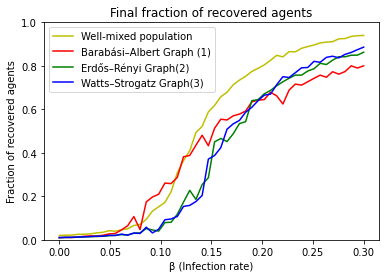

In [ ]:
plt.plot(infection_rates, fraction_recovered_04, label="Well-mixed population", color="y")
plt.plot(infection_rates, fraction_recovered_01, label="Barabási–Albert Graph (1)", color="r")
plt.plot(infection_rates, fraction_recovered_02, label="Erdős–Rényi Graph(2)", color="g")
plt.plot(infection_rates, fraction_recovered_03, label="Watts–Strogatz Graph(3)", color="b")
plt.title('Final fraction of recovered agents')
plt.xlabel("β (Infection rate)")
plt.ylabel("Fraction of recovered agents")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [ ]:
fraction_recovered_04 = simulate_epidemic_scope(facebook_friendship_graph, infection_rates=infection_rates) 

In [ ]:
fraction_recovered_05 = simulate_epidemic_scope(sex_escort_graph, infection_rates=infection_rates) 

In [ ]:
fraction_recovered_06 = simulate_epidemic_scope(contact_tracing_graph, infection_rates=infection_rates) 

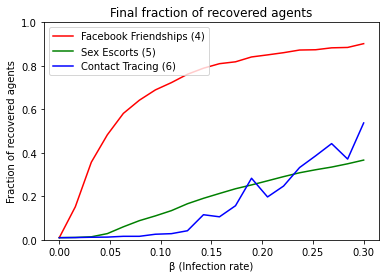

In [ ]:
plt.plot(infection_rates, fraction_recovered_04, label="Facebook Friendships (4)", color="r")
plt.plot(infection_rates, fraction_recovered_05, label="Sex Escorts (5)", color="g")
plt.plot(infection_rates, fraction_recovered_06, label="Contact Tracing (6)", color="b")
plt.title('Final fraction of recovered agents')
plt.xlabel("β (Infection rate)")
plt.ylabel("Fraction of recovered agents")
plt.ylim(0, 1)
plt.legend(loc="upper left")
plt.show()

### 3.2 Experiment 2
Investigating the qualitative effects of different network structures when running SIR epidemics while sweeping over the infection rate.

In [ ]:
def SIR_infection_rate_sweep(graph, infection_rates, recovery_rate=1, n_iterations=10):          
  result = {}
  result['max_T'] = []
  result['min_S'] = []
  result['max_I'] = []
  result['max_R'] = []
  N = graph.number_of_nodes()
  for infection_rate in infection_rates:
    T, S, I, R = [], [], [], []
    for n_iteration in range(n_iterations):
      initial_infecteds = random.sample(list(graph.nodes()), int(0.01*N))
      t, s, i, r = EoN.Gillespie_SIR(graph, infection_rate, recovery_rate, initial_infecteds = initial_infecteds)
      S.append(np.min(s))
      I.append(np.max(i))
      R.append(np.max(r))
      T.append(np.max(t))
    result['max_T'].append(np.mean(T))
    result['min_S'].append(np.mean(S)/N)
    result['max_I'].append(np.mean(I)/N)
    result['max_R'].append(np.mean(R)/N)
  return result

In [ ]:
infection_rates = np.linspace(0, 0.3, 20)
result_01 = SIR_infection_rate_sweep(er_n_1000_k_10, infection_rates);

In [ ]:
def plot_infection_rate_sweep(infection_rates, result):
  plt.plot(infection_rates, result["min_S"], color=S_COLOR, linestyle=S_LINESTYLE, label = 'Min Susceptible')
  plt.plot(infection_rates, result['max_I'], color=I_COLOR, linestyle=I_LINESTYLE, label = 'Max Infected')
  plt.plot(infection_rates, result['max_R'], color=R_COLOR, linestyle=R_LINESTYLE, label = 'Max Recovered')
  plt.title("Effect of different infection rates")
  plt.title('Final fraction of agents')
  plt.xlabel("β (Infection rate)")
  plt.ylabel("Fraction of agents")
  plt.ylim(0, 1)
  plt.legend()

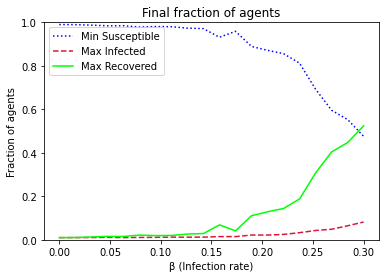

In [ ]:
plot_infection_rate_sweep(infection_rates, result_01)

In [ ]:
result_02 = SIR_infection_rate_sweep(ba_n_1000_k_10, infection_rates);

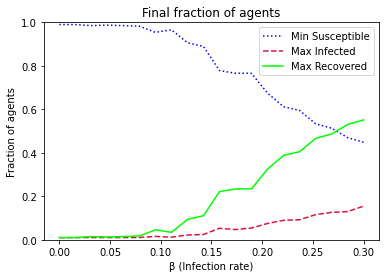

In [ ]:
plot_infection_rate_sweep(infection_rates, result_02)

In [ ]:
result_03 = SIR_infection_rate_sweep(ba_n_1000_k_12, infection_rates);

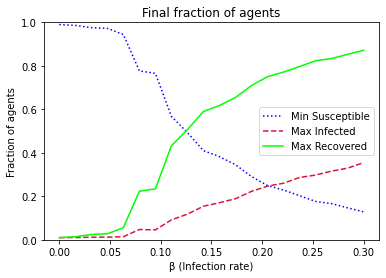

In [ ]:
plot_infection_rate_sweep(infection_rates, result_03)

In [ ]:
result_04 = SIR_infection_rate_sweep(ws_n_1000_k_6, infection_rates);

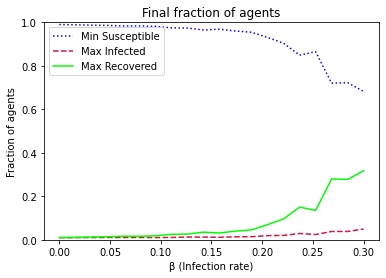

In [ ]:
plot_infection_rate_sweep(infection_rates, result_04)

In [ ]:
    """This function is used in order to simulate mutiple 
    SIR epidemics on the same graph using different
    infection and recovery rates

  Args:
      param1 (int): The first parameter.
      param2 (str): The second parameter.

  Returns:
      bool: The return value. True for success, False otherwise.

  .. _PEP 484:
      https://www.python.org/dev/peps/pep-0484/
  """
def simulate_SIR_epidemic(graph, infection_rate, recovery_rate, initital_size=1, tmin=DEFAULT_TMIN, tmax=DEFAULT_TMAX):
  return EoN.Gillespie_SIR(graph, infection_rate, recovery_rate, initial_infecteds = range(initital_size), tmin=tmin, tmax=tmax)

In [ ]:
def plot_SIR_epidemic(t, S, I, R, title):
  plt.title(title)
  plt.plot(t, S, color="blue", linestyle='dotted', label = 'Susceptible')
  plt.plot(t, I, color="red", linestyle='dashed', label = 'Infected')
  plt.plot(t, R, color="green", linestyle='solid', label = 'Recovered')
  plt.xlabel('$t$')
  plt.ylabel('Number of People')
  plt.legend()  
  plt.show()

In [ ]:
def simulate_SIR_epidemics(graph, infection_rates, recovery_rates, initial_size=1, tmax=TMAX):
  """This function is used in order to simulate mutiple 
    SIR epidemics on the same graph using different
    infection and recovery rates

  Args:
      graph (int): The first parameter.
      infection_rates (str): The second parameter.
      recovery_rates (str): The second parameter.
      initial_size (int): The number of people initially infected with the disease.

  Returns:
      bool: The return value. True for success, False otherwise.

  .. _PEP 484:
      https://www.python.org/dev/peps/pep-0484/

  """
  
  n_i = len(infection_rates)
  n_r = len(recovery_rates)

  results = np.empty([n_i, n_r], dtype=object)
  result_dict = {}

  for i in range(n_i):
    infection_rate = infection_rates[i]
    result_dict[infection_rate] = {}
    for r in range(n_r):
      recovery_rate = recovery_rates[r]
      t, S, I, R = simulate_SIR_epidemic(graph, infection_rate, recovery_rate, initital_size=initial_size, tmax=tmax)
      results[i][r] = (t, S, I, R)
      result_dict[infection_rate][recovery_rate] = simulate_SIR_epidemic(graph, infection_rate, recovery_rate, initital_size=initial_size, tmax=tmax)
  return results

In [ ]:
def plot_SIR_epidemics(graph_name, infection_rates, recovery_rates, results):
  n_i = len(infection_rates)
  n_r = len(recovery_rates)
  fig, axs = plt.subplots(n_i, n_r, figsize=(16,12))
  fig.suptitle("Simulation of SIR Epidemics on {}".format(graph_name), fontsize=14)
  for i in range(n_i):
    infection_rate = infection_rates[i]
    for r in range(n_r):
      recovery_rate = recovery_rates[r]
      t, S, I, R = results[i][r]
      axs[i, r].plot(t, S, color=S_COLOR, linestyle=S_LINESTYLE, label = S_LABEL)
      axs[i, r].plot(t, I, color=I_COLOR, linestyle=I_LINESTYLE, label = I_LABEL)
      axs[i, r].plot(t, R, color=R_COLOR, linestyle=R_LINESTYLE, label = R_LABEL)
      axs[i, r].title.set_text("β: {}, γ: {}".format(infection_rate, recovery_rate))

In [ ]:
def compare_SIR_epidemics(graph_name, infection_rates, recovery_rates, results):
  '''
  This function is supposed to print the S, I, R curves of different simulations 
  in one plot, in order to make the curves better comparable
  '''
  n_i = len(infection_rates)
  n_r = len(recovery_rates)
  # Create four polar axes and access them through the returned array
  fig, axs = plt.subplots(1, 3, figsize=(12,8))
  fig.figsize=(6, 18)
  #axs[0, 0].plot(x, y)
  #axs[1, 1].scatter(x, y)
  for i in range(n_i):
    infection_rate = infection_rates[i]
    for r in range(n_r):
      recover_rate = recovery_rates[i]
      t, S, I, R = results[i][r]
      axs[0].plot(t, S, color="blue", linestyle='dotted', label = 'Susceptible')
      axs[1].plot(t, I, color="red", linestyle='dashed', label = 'Infected')
      axs[2].plot(t, R, color="green", linestyle='solid', label = 'Recovered')

In [ ]:
def simulate_SIR_epidemics_dif_params(graph, parameter_combinations):
  for parameter_combination in parameter_combinations:
    infection_rate = parameter_combination.get("infection_rate", DEFAULT_INFECTION_RATE)
    recovery_rate = parameter_combination.get("recovery_rate", DEFAULT_RECOVERY_RATE)
    tmin = parameter_combination.get("tmin", DEFAULT_TMIN) 
    tmax = parameter_combination.get("tmax", DEFAULT_TMAX)
    initial_size = parameter_combination.get("initial_size", DEFAULT_INITIAL_SIZE)

    t, S, I, R = simulate_SIR_epidemic(graph, infection_rate, recovery_rate, initital_size=initial_size, tmin=tmin, tmax=tmax)
    plot_SIR_epidemic(t, S, I, R, "β: {}, γ: {}".format(infection_rate, recovery_rate))

In [ ]:
def SIR_network_comparison(network_01, name_01, network_02, name_02, parameter_combinations):
    for parameter_combination in parameter_combinations:
      infection_rate = parameter_combination.get("infection_rate", DEFAULT_INFECTION_RATE)
      recovery_rate = parameter_combination.get("recovery_rate", DEFAULT_RECOVERY_RATE)
      tmin = parameter_combination.get("tmin", DEFAULT_TMIN) 
      tmax = parameter_combination.get("tmax", DEFAULT_TMAX)
      initial_size = parameter_combination.get("initial_size", DEFAULT_INITIAL_SIZE)
      fig, axs = plt.subplots(1, 2, figsize=(12,6))
      plt.setp(axs, ylim=(0,1))
      #fig.figsize=(12, 6)
      N1 = network_01.number_of_nodes()
      N2 = network_02.number_of_nodes()

      t1, S1, I1, R1 = EoN.Gillespie_SIR(network_01, infection_rate, recovery_rate, initial_infecteds = range(initial_size), tmax=tmax)
      t2, S2, I2, R2 = EoN.Gillespie_SIR(network_02, infection_rate, recovery_rate, initial_infecteds = range(initial_size), tmax=tmax)
      #plot_SIR_epidemic(t, S, I, R, "β: {}, γ: {}".format(infection_rate, recovery_rate))

      axs[0].plot(t1, S1/N1, color=S_COLOR, linestyle='dotted', label = 'Susceptible')
      axs[0].plot(t1, I1/N1, color=I_COLOR, linestyle='dashed', label = 'Infected')
      axs[0].plot(t1, R1/N1, color=R_COLOR, linestyle='solid', label = 'Recovered')
      axs[0].title.set_text("Network: {0} \n Disease: β={1}, γ={2}".format(name_01, infection_rate, recovery_rate))

      axs[1].plot(t2, S2/N2, color=S_COLOR, linestyle='dotted', label = 'Susceptible')
      axs[1].plot(t2, I2/N2, color=I_COLOR, linestyle='dashed', label = 'Infected')
      axs[1].plot(t2, R2/N2, color=R_COLOR, linestyle='solid', label = 'Recovered')
      axs[1].title.set_text("Network: {0} \n Disease: β={1}, γ={2}".format(name_02, infection_rate, recovery_rate))

      #plt.xlim([0, TMIN])
      #plt.show()

### 3.2 Experiment 4
Compares the impact of different measures that lower the infection rate at different time steps with different before/after measure infection rates

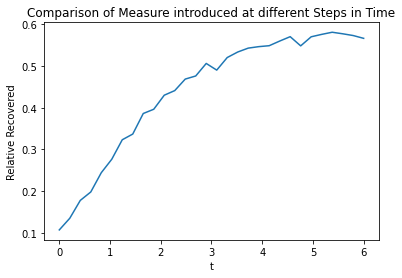

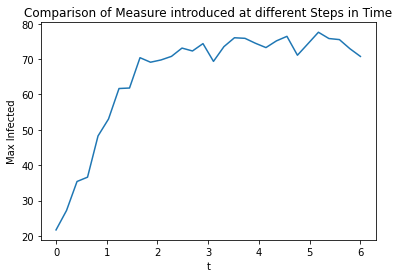

In [ ]:
@retry
def simulate_measure_reducing_infection_rate(gr, inf_rate_before, intervention_at, inf_rate_after, rho, num_iter=50):
  recovered_rates = []
  max_is = []
  for i in range(num_iter):
    total_nodes = gr.number_of_nodes()
    before_ld = EoN.Gillespie_SIR(gr,inf_rate_before,1.0,tmin=0,tmax=intervention_at,return_full_data=True, rho=rho)
    status_dict = {node: before_ld.node_status(node, intervention_at) for node in gr.nodes}
    recovered_before_ld = [node for node in gr.nodes if status_dict[node] == 'R']
    infected_before_ld = [node for node in gr.nodes if status_dict[node] == 'I']
    after_ld = EoN.Gillespie_SIR(gr,inf_rate_after,1.0,tmin=0,return_full_data=True, initial_infecteds=infected_before_ld, initial_recovereds=recovered_before_ld)
    status_dict_after = {node: after_ld.node_status(node, max(after_ld.t())) for node in gr.nodes}
    recovered_after_ld = [node for node in gr.nodes if status_dict_after[node] == 'R']
    infected_after_ld = [node for node in gr.nodes if status_dict_after[node] == 'I']
    recovered_rates.append(len(recovered_after_ld) / total_nodes)
    max_is.append(max(max(before_ld.I()), max(after_ld.I())))
  return sum(recovered_rates) / len(recovered_rates), sum(max_is) / len(max_is)

intro_at = np.linspace(0., 6., 6 * 5)
ret_vals = []

inf_bef = 0.3
rho = 0.05
inf_after = 0.075

for intro in intro_at:
  ret_vals.append(simulate_measure_reducing_infection_rate(contact_tracing_graph, inf_bef, intro, inf_after, rho=rho))

plt.plot(intro_at, [ret_val[0] for ret_val in ret_vals], label="Contact Tracing Graph")
plt.title("Comparison of Measure introduced at different Steps in Time")
plt.xlabel("t")
plt.ylabel("Relative Recovered")
plt.show()

plt.plot(intro_at, [ret_val[1] for ret_val in ret_vals], label="Contact Tracing Graph")
plt.title("Comparison of Measure introduced at different Steps in Time")
plt.xlabel("t")
plt.ylabel("Max Infected")
plt.show()

### 3.2 Experiment 5
Simulate measure that cuts edges of the graph (lockdown = stay at home)

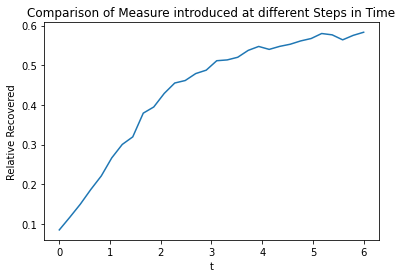

In [ ]:
# TODO: maybe we can also compare max infections?
@retry
def simulate_edge_cutting_at(gr, inf_rate, edge_cutting_at, edge_cutting_ratio, rho, num_iter=50):
  recovered_rates = []

  for i in range(num_iter):
    total_nodes = gr.number_of_nodes()
    before_ld = EoN.Gillespie_SIR(gr,inf_rate,1.0,tmin=0,tmax=edge_cutting_at,return_full_data=True, rho=rho)
    status_dict = {node: before_ld.node_status(node, edge_cutting_at) for node in gr.nodes}
    recovered_before_ld = [node for node in gr.nodes if status_dict[node] == 'R']
    infected_before_ld = [node for node in gr.nodes if status_dict[node] == 'I']
    gr_new = gr.copy()
    all_edges = list(gr_new.edges)
    random.shuffle(all_edges)
    remove_until = m.floor(len(all_edges) * edge_cutting_ratio)
    gr_new.remove_edges_from(all_edges[:remove_until])
    after_ld = EoN.Gillespie_SIR(gr_new,inf_rate,1.0,tmin=0,return_full_data=True, initial_infecteds=infected_before_ld, initial_recovereds=recovered_before_ld)
    status_dict_after = {node: after_ld.node_status(node, max(after_ld.t())) for node in gr.nodes}
    recovered_after_ld = [node for node in gr.nodes if status_dict_after[node] == 'R']
    infected_after_ld = [node for node in gr.nodes if status_dict_after[node] == 'I']
    recovered_rates.append(len(recovered_after_ld) / total_nodes)
  return sum(recovered_rates) / len(recovered_rates)

intro_at = np.linspace(0., 6., 6 * 5)
ret_vals = []

inf_bef = 0.3
rho = 0.05
cutting_ratio = 0.75

for intro in intro_at:
  ret_vals.append(simulate_edge_cutting_at(contact_tracing_graph, inf_bef, intro, cutting_ratio, rho=rho))

plt.plot(intro_at, ret_vals, label="Contact Tracing Graph")
plt.title("Comparison of Measure introduced at different Steps in Time")
plt.xlabel("t")
plt.ylabel("Relative Recovered")
plt.show()

### Experiment 6
=> Research the effect of the sirs SIRS Epidemic

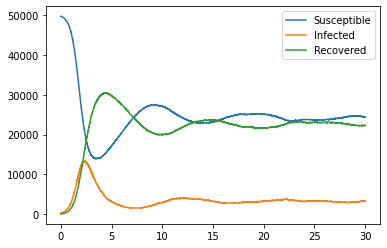

In [ ]:
N = 50000
G = nx.fast_gnp_random_graph(N, 5./(N-1))

H = nx.DiGraph()  #DiGraph showing possible transitions that don't require an interaction
H.add_edge('I', 'R', rate = 1.4)   #I->R
H.add_edge('R', 'S', rate = 0.2)   #R->S

J = nx.DiGraph()    #DiGraph showing transition that does require an interaction.
J.add_edge(('I', 'S'), ('I', 'I'), rate = 1)  #IS->II

IC = defaultdict(lambda: 'S')
for node in range(200):
    IC[node] = 'I'

return_statuses = ('S', 'I', 'R')

t, S, I, R = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses, tmax = 30)

plt.plot(t, S, label = 'Susceptible')
plt.plot(t, I, label = 'Infected')
plt.plot(t, R, label = 'Recovered')
plt.legend()
#plt.savefig('SIRS.png')

### <<< STABLE PART ENDS HERE <<<
### >>> EXPERIMENTAL PART BEGINS HERE >>> 

### Compare T, S, I, R

In [ ]:
@retry
def get_averaged_values_sir(gr, infection_rate=0.5, recovery_rate=1.0, n_iter=10, t_max=10, n_initial_infected = 5, print_prog=False):
  T_VALUES = []
  S_VALUES = [] 
  I_VALUES = []
  R_VALUES = []
  all_nodes = list(gr.nodes)

  for i in range(n_iter):
    shuffle(all_nodes)
    t, S, I, R = EoN.Gillespie_SIR(gr, infection_rate, recovery_rate, initial_infecteds = all_nodes[:n_initial_infected], tmax=t_max)
    T_VALUES.append(max(t))
    S_VALUES.append(min(S))
    I_VALUES.append(max(I))
    R_VALUES.append(max(R))
    if print_prog:
      print("Simulation {} => Max T: {}, Min S: {}, Max I: {}, Max R: {}".format(i, MAX_T, MIN_S, MAX_I, MAX_R))
  
  return np.array(T_VALUES).mean(), np.array(T_VALUES).std(), np.array(S_VALUES).mean(), np.array(S_VALUES).std(), np.array(I_VALUES).mean(), np.array(I_VALUES).std(), np.array(R_VALUES).mean(), np.array(R_VALUES).std()

#### Haslemere

In [ ]:
hm_avg_t, hm_std_t, hm_avg_s, hm_std_s, hm_avg_i, hm_std_i, hm_avg_r, hm_std_r = get_averaged_values_sir(contact_tracing_graph, n_iter=100, infection_rate=0.3)
print(hm_avg_t, hm_std_t, hm_avg_s, hm_std_s, hm_avg_i, hm_std_i, hm_avg_r, hm_std_r)

8.897530339150714 1.634867870238924 205.67 58.3857953615432 59.11 19.326611187686268 210.53 58.161061716581486


In [ ]:
graph_ba_hm = nx.barabasi_albert_graph(len(contact_tracing_graph.nodes), int(len(contact_tracing_graph.edges) / len(contact_tracing_graph.nodes)))
ba_avg_t, ba_std_t, ba_avg_s, ba_std_s, ba_avg_i, ba_std_i, ba_avg_r, ba_std_r = get_averaged_values_sir(graph_ba_hm, n_iter=100, infection_rate=0.3)
print(ba_avg_t, ba_std_t, ba_avg_s, ba_std_s, ba_avg_i, ba_std_i, ba_avg_r, ba_std_r)

8.771242348195253 1.905836033871393 215.66 64.90950931874313 57.44 20.8347402191628 198.99 66.42356434278426


In [ ]:
graph_ws_hm = nx.watts_strogatz_graph(len(contact_tracing_graph.nodes), int(len(contact_tracing_graph.edges) / len(contact_tracing_graph.nodes)), 0.5)
ws_avg_t, ws_std_t, ws_avg_s, ws_std_s, ws_avg_i, ws_std_i, ws_avg_r, ws_std_r = get_averaged_values_sir(graph_ws_hm, n_iter=100, infection_rate=0.3)
print(ws_avg_t, ws_std_t, ws_avg_s, ws_std_s, ws_avg_i, ws_std_i, ws_avg_r, ws_std_r)

3.018881102053687 1.6543597350323407 409.8 2.9631064780058103 5.93 1.4782083750270123 8.2 2.9631064780058107


In [ ]:
print(tabulate([
                ["Haslemere", hm_avg_t, hm_avg_s, hm_avg_i, hm_avg_r],
                ["Barabasi Albert", ba_avg_t, ba_avg_s, ba_avg_i, ba_avg_r],
                ["Watts Strogatz", ws_avg_t, ws_avg_s, ws_avg_i, ws_avg_r]
                ], headers=["Network", "Max t", "Max S", "Max I", "Max R"]))

Network            Max t    Max S    Max I    Max R
---------------  -------  -------  -------  -------
Haslemere        8.89753   205.67    59.11   210.53
Barabasi Albert  8.77124   215.66    57.44   198.99
Watts Strogatz   3.01888   409.8      5.93     8.2


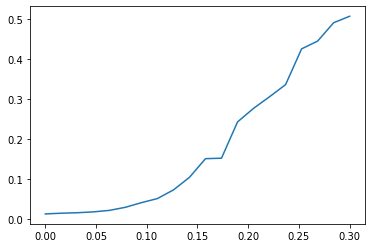

In [ ]:
def plot_inf_rate_vs_final_r(graph, inf_rates = np.linspace(0,0.3,20)):
  final_rs = []
  for inf_rate in inf_rates:
    gr_avg_t, gr_std_t, gr_avg_s, gr_std_s, gr_avg_i, gr_std_i, gr_avg_r, gr_std_r = get_averaged_values_sir(graph, n_iter=100, infection_rate=inf_rate)
    final_rs.append(gr_avg_r / len(list(graph.nodes)))
  plt.plot(inf_rates, final_rs)
  return inf_rates, final_rs
  plt.title("Final Rate Recovered per infection rate and recovery rate = 1.0")
  plt.xlabel("Infection Rate")
  plt.ylabel("Fraction Recovered")
  plt.show()

def plot_rec_rate_vs_final_r(graph, rec_rates = [i * 0.1 for i in range(11)]):
  final_rs = []
  for rec_rate in rec_rates:
    gr_avg_t, gr_std_t, gr_avg_s, gr_std_s, gr_avg_i, gr_std_i, gr_avg_r, gr_std_r = get_averaged_values_sir(graph, n_iter=100, recovery_rate=rec_rate, infection_rate=0.4)
    final_rs.append(gr_avg_r / len(list(graph.nodes)))
  plt.plot(rec_rates, final_rs)
  plt.title("Final Rate Recovered per recovery rate and infection rate = 0.4")
  plt.xlabel("Recovery Rate")
  plt.ylabel("Fraction Recovered")
  plt.show()

infection_rates_03, fraction_recovered_03 = plot_inf_rate_vs_final_r(graph_haslemere)
#plot_rec_rate_vs_final_r(graph_haslemere)

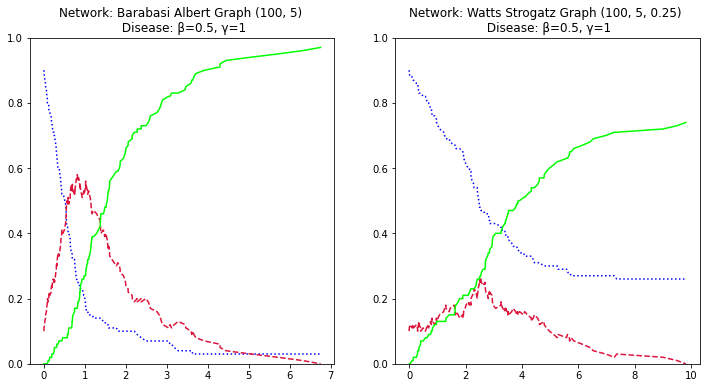

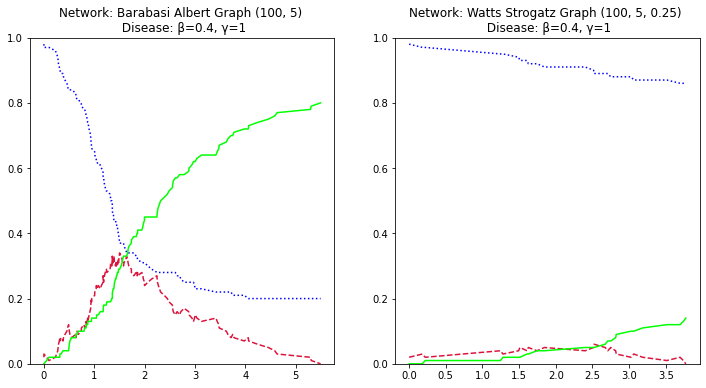

In [ ]:
#infection_rates = [0.3, 0.6, 0.9]
#recovery_rates = [0.6, 0.9, 1.2]
#results = simulate_SIR_epidemics(barabasi_albert_graph_small, infection_rates, recovery_rates, tmax=TMAX);
#plot_SIR_epidemics("Barabasi Albert Graph (100, 5)", infection_rates, recovery_rates, results)
parameter_combinations = [
  {"infection_rate": 0.5, "recovery_rate": 1, "tmin": TMIN, "tmax":TMAX, "initial_size": 10},
  {"infection_rate": 0.4, "recovery_rate": 1, "tmin": TMIN, "tmax":TMAX, "initial_size": 2},
]
barabasi_albert_graph_small = nx.barabasi_albert_graph(100,5)
watts_strogatz_graph_small = nx.watts_strogatz_graph(100,5, 0.25)
SIR_network_comparison(barabasi_albert_graph_small, "Barabasi Albert Graph (100, 5)", watts_strogatz_graph_small, "Watts Strogatz Graph (100, 5, 0.25)", parameter_combinations)

In [ ]:
infection_rate=0.
recovery_rate=1
initial_infecteds=range(10)
tmax=20

T_VALUES = []
S_VALUES = [] 
I_VALUES = []
R_VALUES = []
for i in range(10):
  sim = EoN.Gillespie_SIR(ba_n_1000_k_10, infection_rate, recovery_rate, return_full_data=True, initial_infecteds = initial_infecteds , tmax=tmax)
  T = sim.t()
  MAX_T = np.max(T)
  T_VALUES.append(MAX_T)
  S = sim.S()
  MIN_S = np.min(S)
  S_VALUES.append(MIN_S)
  I = sim.I()
  MAX_I = np.max(I)
  I_VALUES.append(MAX_I)
  R = sim.R()
  MAX_R = np.max(R)
  R_VALUES.append(MAX_R)
  print("Simulation {} => Max T: {}, Min S: {}, Max I: {}, Max R: {}".format(i, MAX_T, MIN_S, MAX_I, MAX_R))

AVG_MAX_T = average(T_VALUES)
AVG_MIN_S = average(S_VALUES)
AVG_MAX_I = average(I_VALUES)
AVG_MAX_R = average(R_VALUES)
print("Avg Max T: {}, Avg Min S: {}, Avg Max I: {}, Avg Max R: {}".format(AVG_MAX_T, AVG_MIN_S, AVG_MAX_I, AVG_MAX_R))

Simulation 0 => Max T: 12.579676312224832, Min S: 713, Max I: 74, Max R: 287
Simulation 1 => Max T: 9.228875531231036, Min S: 656, Max I: 100, Max R: 344
Simulation 2 => Max T: 9.032260523289352, Min S: 666, Max I: 108, Max R: 334
Simulation 3 => Max T: 10.530956088601547, Min S: 706, Max I: 72, Max R: 294
Simulation 4 => Max T: 14.219965366217961, Min S: 678, Max I: 55, Max R: 322
Simulation 5 => Max T: 11.868227017026156, Min S: 662, Max I: 89, Max R: 338
Simulation 6 => Max T: 7.894244016775498, Min S: 624, Max I: 102, Max R: 376
Simulation 7 => Max T: 13.013996425493596, Min S: 605, Max I: 90, Max R: 395
Simulation 8 => Max T: 15.948528867781485, Min S: 573, Max I: 113, Max R: 427
Simulation 9 => Max T: 8.591611223775946, Min S: 712, Max I: 83, Max R: 288
Avg Max T: 11.290834137241742, Avg Min S: 659.5, Avg Max I: 88.6, Avg Max R: 340.5


In [ ]:
infection_rate=0.2
recovery_rate=1
initial_infecteds=range(10)
tmax=20

T_VALUES = []
S_VALUES = [] 
I_VALUES = []
R_VALUES = []
for i in range(10):
  sim = EoN.Gillespie_SIR(er_n_1000_k_10, infection_rate, recovery_rate, return_full_data=True, initial_infecteds = initial_infecteds , tmax=tmax)
  T = sim.t()
  MAX_T = np.max(T)
  T_VALUES.append(MAX_T)
  S = sim.S()
  MIN_S = np.min(S)
  S_VALUES.append(MIN_S)
  I = sim.I()
  MAX_I = np.max(I)
  I_VALUES.append(MAX_I)
  R = sim.R()
  MAX_R = np.max(R)
  R_VALUES.append(MAX_R)
  print("Simulation {} => Max T: {}, Min S: {}, Max I: {}, Max R: {}".format(i, MAX_T, MIN_S, MAX_I, MAX_R))

N_NODES = er_n_1000_k_10.number_of_nodes
AVG_MAX_T = average(T_VALUES) / N_NODES
AVG_MIN_S = average(S_VALUES) / N_NODES
AVG_MAX_I = average(I_VALUES) / N_NODES
AVG_MAX_R = average(R_VALUES) / N_NODES

print("Avg Max T: {}, Avg Min S: {}, Avg Max I: {}, Avg Max R: {}".format(AVG_MAX_T, AVG_MIN_S, AVG_MAX_I, AVG_MAX_R))

Simulation 0 => Max T: 10.056634216395755, Min S: 906, Max I: 21, Max R: 94
Simulation 1 => Max T: 17.736386914308536, Min S: 759, Max I: 29, Max R: 241
Simulation 2 => Max T: 4.060297486542938, Min S: 974, Max I: 17, Max R: 26
Simulation 3 => Max T: 3.176392281002847, Min S: 978, Max I: 12, Max R: 22
Simulation 4 => Max T: 13.057222115836591, Min S: 912, Max I: 17, Max R: 88
Simulation 5 => Max T: 7.640861576917663, Min S: 965, Max I: 13, Max R: 35
Simulation 6 => Max T: 10.548914924722636, Min S: 868, Max I: 27, Max R: 132
Simulation 7 => Max T: 10.992578914452759, Min S: 910, Max I: 16, Max R: 90
Simulation 8 => Max T: 9.540719810763186, Min S: 942, Max I: 13, Max R: 58
Simulation 9 => Max T: 6.9350838344728345, Min S: 970, Max I: 10, Max R: 30


TypeError: ignored

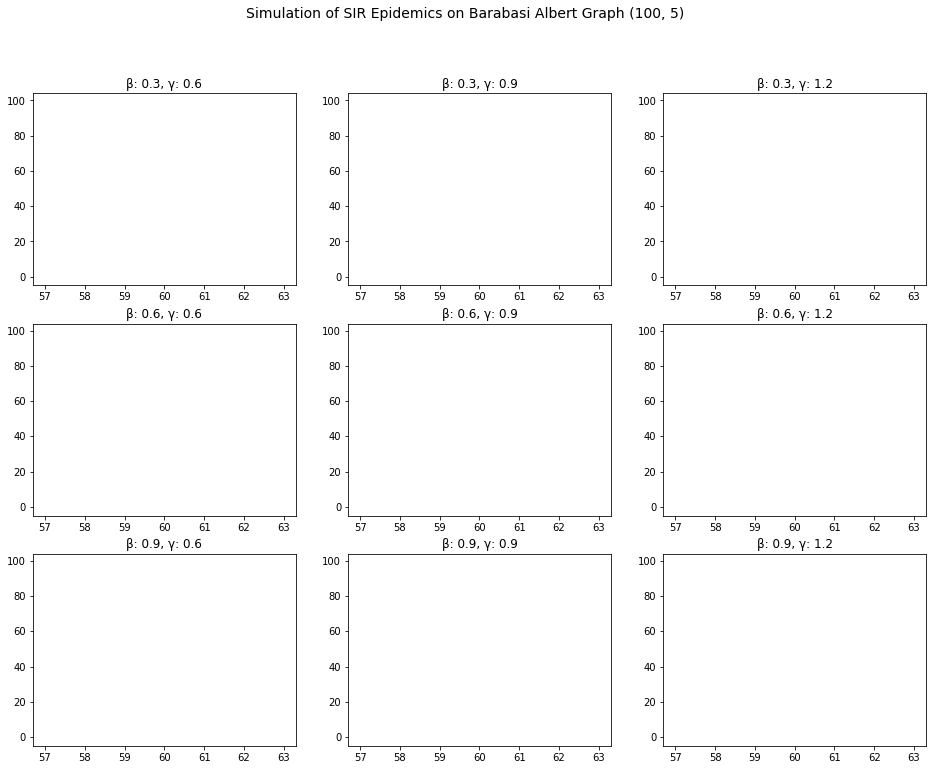

In [ ]:
infection_rates = [0.3, 0.6, 0.9]
recovery_rates = [0.6, 0.9, 1.2]
results = simulate_SIR_epidemics(barabasi_albert_graph_small, infection_rates, recovery_rates, tmax=TMAX);
plot_SIR_epidemics("Barabasi Albert Graph (100, 5)", infection_rates, recovery_rates, results)

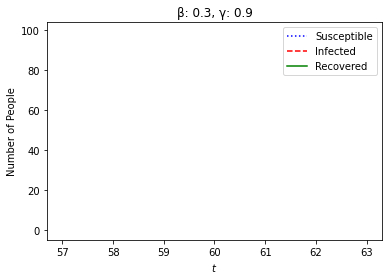

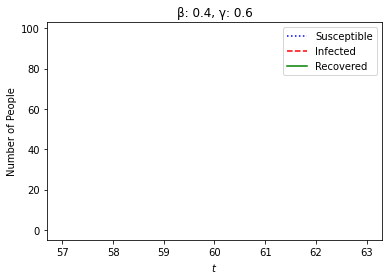

In [ ]:
parameter_combinations = [
  {"infection_rate": 0.3, "recovery_rate": 0.9, "tmin": TMIN, "tmax":TMAX, "initial_size": 1},
  {"infection_rate": 0.4, "recovery_rate": 0.6, "tmin": TMIN, "tmax":TMAX, "initial_size": 2},
]
results = simulate_SIR_epidemics_dif_params(barabasi_albert_graph_small, parameter_combinations);

The peak of infected people is 10719


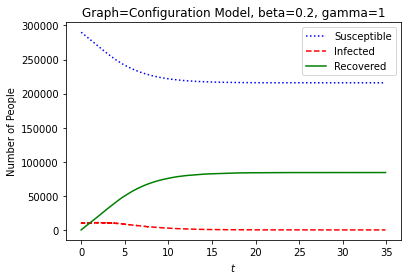

The peak of infected people is 49087


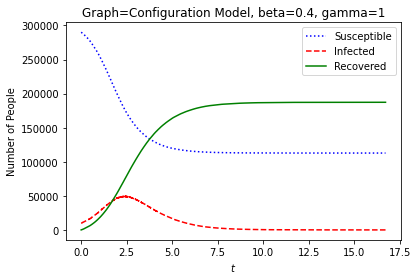

The peak of infected people is 80248


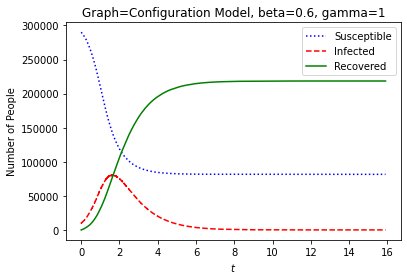

In [ ]:
G = nx.configuration_model([1,5,10]*100000)
initial_size = 10000

recovery_rate = 1
infection_rates = np.linspace(0.2, 0.6, 3)
for infection_rate in infection_rates: # infection rate
  t, S, I, R = simulate_SIR_epidemic(G, infection_rate, recovery_rate, initial_size)
  print("The peak of infected people is {}".format(np.amax(I)))
  plot_SIR_epidemic(t, S, I, R, "Graph={}, beta={}, gamma={}".format("Configuration Model", infection_rate, recovery_rate))

The peak of infected people is 18010


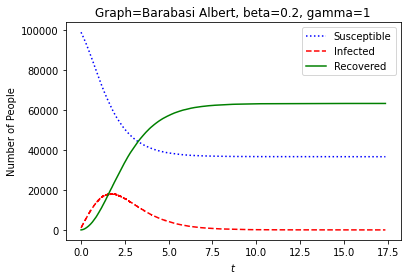

The peak of infected people is 37128


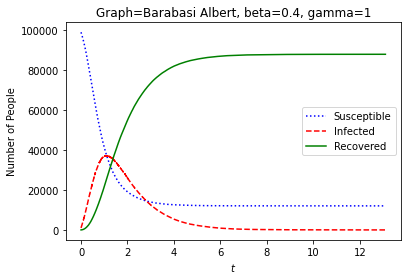

The peak of infected people is 48099


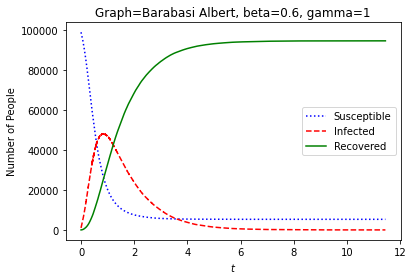

In [ ]:
G = nx.barabasi_albert_graph(10**5, 5)
initial_size = 1000

recovery_rate = 1
infection_rates = np.linspace(0.2, 0.6, 3)
for infection_rate in infection_rates: # infection rate
  t, S, I, R = simulate_SIR_epidemic(G, infection_rate, recovery_rate, initial_size)
  print("The peak of infected people is {}".format(np.amax(I)))
  plot_SIR_epidemic(t, S, I, R, "Graph={}, beta={}, gamma={}".format("Barabasi Albert", infection_rate, recovery_rate))

In [ ]:
erdos_renyi_graph(n, p, seed=None, directed=False)
G = nx.barabasi_albert_graph(10**5, 5)
initial_size = 1000

recovery_rate = 1
infection_rates = np.linspace(0.2, 0.6, 3)
for infection_rate in infection_rates: # infection rate
  t, S, I, R = simulate_SIR_epidemic(G, infection_rate, recovery_rate, initial_size)
  print("The peak of infected people is {}".format(np.amax(I)))
  plot_SIR_epidemic(t, S, I, R, "Graph={}, beta={}, gamma={}".format("Barabasi Albert", infection_rate, recovery_rate))

#### Experiment 01

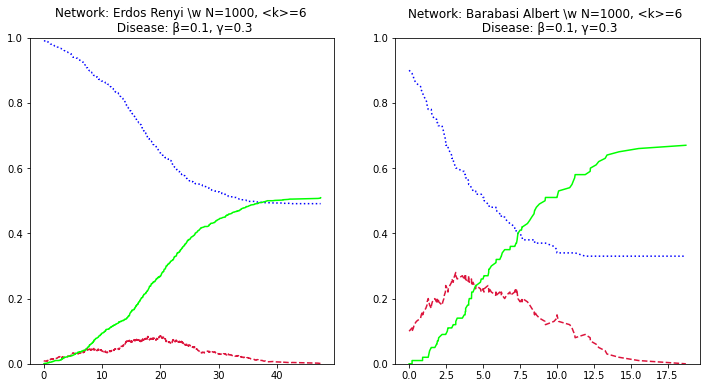

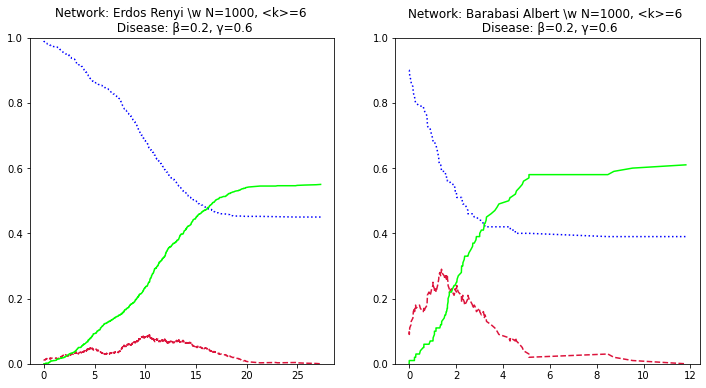

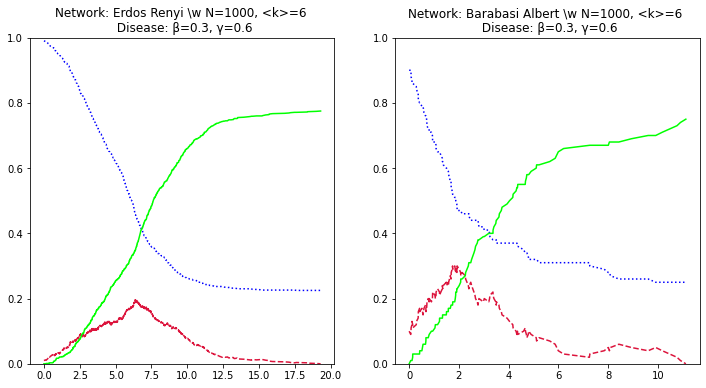

In [ ]:
#analyze_graph(er_n_1000_k_10)
#analyze_graph(ba_n_1000_k_10)

parameter_combinations = [
  {"infection_rate": 0.1, "recovery_rate": 0.3, "tmin": TMIN, "tmax":TMAX, "initial_size": 10},
  {"infection_rate": 0.2, "recovery_rate": 0.6, "tmin": TMIN, "tmax":TMAX, "initial_size": 10},#
  {"infection_rate": 0.3, "recovery_rate": 0.6, "tmin": TMIN, "tmax":TMAX, "initial_size": 10},#
]
SIR_network_comparison(er_n_1000_k_10, "Erdos Renyi \w N=1000, <k>=10", ba_n_1000_k_10, "Barabasi Albert \w N=1000, <k>=10",  parameter_combinations)

In [ ]:
import EoN
import networkx as nx
from matplotlib import rc
import matplotlib.pylab as plt


import scipy
import random



colors = ['#5AB3E6','#FF2000','#009A80','#E69A00', '#CD9AB3', '#0073B3',
        '#F0E442']

#commands to make legend be in LaTeX font
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)



rho = 0.025
target_k = 6
N=10000
tau = 0.5
gamma = 1.
ts = scipy.arange(0,40,0.05)
count = 50 #number of simulations to run for each



def generate_network(Pk, N, ntries = 100):
    r'''Generates an N-node random network whose degree distribution is given by Pk'''
    counter = 0
    while counter< ntries:
        counter += 1
        ks = []
        for ctr in range(N):
            ks.append(Pk())
        if sum(ks)%2 == 0:
            break
    if sum(ks)%2 ==1:
        raise EoN.EoNError("cannot generate even degree sum")
    G = nx.configuration_model(ks)
    return G



#An erdos-renyi network has a Poisson degree distribution.
def PkPoisson():
    return scipy.random.poisson(target_k)
def PsiPoisson(x):
    return scipy.exp(-target_k*(1-x))
def DPsiPoisson(x):
    return target_k*scipy.exp(-target_k*(1-x))



#a regular (homogeneous) network has a simple generating function.

def PkHomogeneous():
    return target_k
def PsiHomogeneous(x):
    return x**target_k
def DPsiHomogeneous(x):
    return target_k*x**(target_k-1)




#The following 30 - 40 lines or so are devoted to defining the degree distribution
#and the generating function of the truncated power law network.

#defining the power law degree distribution here:
assert(target_k==6) #if you've changed target_k, then you'll
                #want to update the range 1..61 and/or
                #the exponent 1.5.

PlPk = {}
exponent = 1.5
kave = 0
for k in range(1,61):
    PlPk[k]=k**(-exponent)
    kave += k*PlPk[k]

normfactor= sum(PlPk.values())
for k in PlPk:
    PlPk[k] /= normfactor

def PkPowLaw():
    r = random.random()
    for k in PlPk:
        r -= PlPk[k]
        if r<0:
            return k

def PsiPowLaw(x):
    #print PlPk
    rval = 0
    for k in PlPk:
        rval += PlPk[k]*x**k
    return rval

def DPsiPowLaw(x):
    rval = 0
    for k in PlPk:
        rval += k*PlPk[k]*x**(k-1)
    return rval
#End of power law network properties.





def process_degree_distribution(N, Pk, color, Psi, DPsi, symbol, label, count):
    report_times = scipy.linspace(0,30,3000)
    sums = 0*report_times
    for cnt in range(count):
        G = generate_network(Pk, N)
        t, S, I, R = EoN.fast_SIR(G, tau, gamma, rho=rho)
        plt.plot(t, I*1./N, '-', color = color,
                                alpha = 0.1, linewidth=1)
        subsampled_I = EoN.subsample(report_times, t, I)
        sums += subsampled_I*1./N
    ave = sums/count
    plt.plot(report_times, ave, color = 'k')

    #Do EBCM
    N= G.order()#N is arbitrary, but included because our implementation of EBCM assumes N is given.
    t, S, I, R = EoN.EBCM_uniform_introduction(N, Psi, DPsi, tau, gamma, rho, tmin=0, tmax=10, tcount = 41)
    plt.plot(t, I/N, symbol, color = color, markeredgecolor='k', label=label)

    for cnt in range(3):  #do 3 highlighted simulations
        G = generate_network(Pk, N)
        t, S, I, R = EoN.fast_SIR(G, tau, gamma, rho=rho)
        plt.plot(t, I*1./N, '-', color = 'k', linewidth=0.1)




plt.figure(figsize=(8,4))



#Powerlaw
process_degree_distribution(N, PkPowLaw, colors[3], PsiPowLaw, DPsiPowLaw, 'd', r'Truncated Power Law', count)

#Poisson
process_degree_distribution(N, PkPoisson, colors[0], PsiPoisson, DPsiPoisson, '^', r'Erd\H{o}s--R\'{e}nyi', count)

#Homogeneous
process_degree_distribution(N, PkHomogeneous, colors[2], PsiHomogeneous, DPsiHomogeneous, 's', r'Homogeneous', count)

plt.xlabel(r'$t$', fontsize=12)
plt.ylabel(r'Proportion infected', fontsize=12)
plt.legend(loc = 'upper right', numpoints = 1)

plt.axis(xmax=10, xmin=0, ymin=0)
plt.savefig('fig1p2.pdf')

ModuleNotFoundError: ignored